In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import numpy as np
#import pandas as pd

from IPython.display import display, HTML
import tensorflow as tf
#import numpy as np
#import pandas as pd
#import random as ran
import h5py

import pandas as pd


In [2]:
def Overlap_calc(hp,sp,psd):
    f_low = 20
    m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    o = overlap(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    return m


In [3]:
def _preprocess_data(data, num, samples):
    new_array = []
    for i in range(num):
        dataset = data[i]
        if((dataset.max() != 0.0) and (dataset.min() != 0.0)):
            maximum = np.max(dataset)
            minimum = np.abs(np.min(dataset))
            for j in range(samples):
                if(dataset[j] > 0):
                    dataset[j] = dataset[j]/maximum
                else:
                    dataset[j] = dataset[j]/minimum
        new_array.append(dataset)
    return new_array, maximum, minimum


In [4]:
# Split a univariate sequence into samples
#def split_sequence(sequence_noisy,sequence_pure,n_steps):
def split_sequence(sequence_noisy,n_steps):
    X = [] 
#    y = []
    for i in range(len(sequence_noisy)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence_noisy)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence_noisy[i:end_ix] 
#        seq_y = sequence_pure[end_ix]
        X.append(seq_x)
#        y.append(seq_y)
#    return array(X), array(y)
    return np.array(X)
    
    
#def reshape_sequences(self, num, data_noisy, data_pure):
def reshape_sequences(num, data_noisy):
    n_steps = 10
    arr_noisy = []
#    arr_pure = []
        
    for i in range(num):
        X_noisy = data_noisy[i]
#        X_pure = data_pure[i]
        X_noisy = np.pad(X_noisy, (n_steps, n_steps), 'constant', constant_values=(0, 0))
#        X_pure = np.pad(X_pure, (n_steps, n_steps), 'constant', constant_values=(0, 0))
        # split into samples
#        X, y = self.split_sequence(X_noisy, X_pure, n_steps)
        X = split_sequence(X_noisy, n_steps)
        arr_noisy.append(X)
#        arr_pure.append(y)
    
    arr_noisy = np.asarray(arr_noisy)
#    arr_pure = np.asarray(arr_pure)
        
#    return arr_noisy, arr_pure
    return arr_noisy


In [5]:
class FractalTanimotoLoss(tf.keras.losses.Loss):
        def __init__(lr, base_lr=2e-3, depth=0, smooth=1e-6, **kwargs):
            depth = depth
            learning_rate = lr
            base_lr = base_lr
            smooth = smooth
            super().__init__(**kwargs)
    
        def inner_prod(self, y, x):
            prod = y*x
            prod = K.sum(prod, axis=1)
        
            return prod
    
        def tnmt_base(x, y, scale):

            tpl  = inner_prod(y,x)
            tpp  = inner_prod(y,y)
            tll  = inner_prod(x,x)


            num = tpl + self.smooth
            denum = 0.0
            result = 0.0
            for d in range(depth):
                a = 2.**d
                b = -(2.*a-1.)

                denum = denum + tf.math.reciprocal( a*(tpp+tll) + b *tpl + smooth)
                
            result =  num * denum * scale
            
            return  result*scale
        
        def call(y_true, y_pred):
            
            if(learning_rate < base_lr):
                depth = depth + 5
                
            depth = depth+1
            scale = 1./len(range(depth))
            
            l1 = K.mean(K.square(y_pred - y_true),axis=-1)
            result = tnmt_base(y_true, y_pred, scale)
        
            return  l1 - 0.01*result
        
        def get_config(self):
            base_config = super().get_config()
            return {**base_config, "depth": depth}   
    

# GW170104

In [10]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW170104_rec_signal_time_L1_1.dat",header=0,delimiter=" ")


In [11]:
np.where((input_data['#time,'].values > 1167559936.598) & (input_data['#time,'].values < 1167559936.600))[0]


array([7781, 7782])

In [12]:
7781 -(1024*0.8)

6961.8

In [13]:
7781 + (1024*0.2)

7985.8

In [14]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW170104.hdf', 'r')
strain = f1['GW170104-v2']['l1_strain'][()]


In [15]:
strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 2048)
strain = np.array(strain)


In [16]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [17]:
#from keras.models import load_model

model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
 
# load model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2058, 10, 32)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2058, 10, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2058, 5, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2058, 5, 16)      1552      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 2058, 5, 16)      0

In [18]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


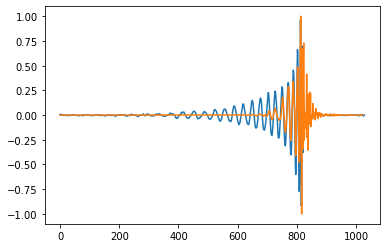

In [19]:
plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[6962:7986][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [20]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[6962:7986]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[6962:7986]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [21]:
with open('/fred/oz016/Chayan/samplegen_old/output/GW170104_L1_psd.dat', 'r') as file:
    freq = []
    psd = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            freq.append(col1)
            psd.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")
            
    freq = np.array(freq)
    psd = np.array(psd)


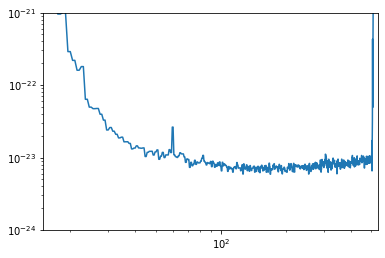

In [22]:
plt.plot(freq, np.sqrt(psd))
plt.xlim(15,)
plt.ylim(1e-24, 1e-21)
plt.xscale('log')
plt.yscale('log')


In [23]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170104_reconstruction_CI_dilated_CNN_10_timesteps_L1_cWB_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


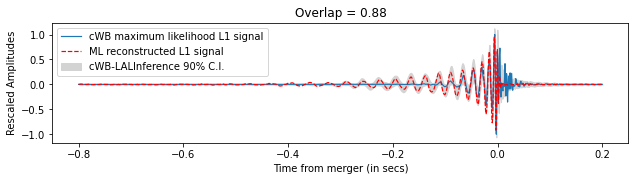

In [24]:
plot_reconstructed(decoded_signals[0][::2][0:1024].astype('float64'), np.squeeze(cwb_reconst).astype('float64'), new_upper, new_lower, psd)


# PE comparison

In [25]:
# Replace 'filename.dat' with your file path
with open('/fred/oz016/Chayan/samplegen_old/output/GW170104_maxl_li_signal_time_L1.dat', 'r') as file:
    time = []
    amp = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            time.append(col1)
            amp.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")

time = np.array(time)
amp = np.array(amp)


In [26]:
np.where((time > 1167559936.598) & (time < 1167559936.600))[0]


array([7781, 7782])

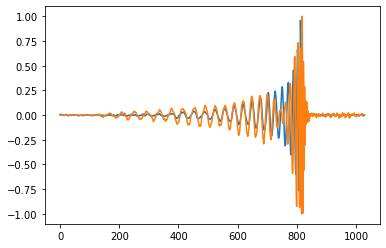

In [27]:
plt.plot(decoded_signals[0][::2])

pe_reconst = amp[6962:7986][None,:]
pe_reconst, maximum, minimum = _preprocess_data(pe_reconst,1,1024)

plt.plot(pe_reconst[0])


In [28]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[6962:7986]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[6962:7986]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [30]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='PE maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='PE-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170104_reconstruction_CI_dilated_CNN_10_timesteps_L1_PE_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


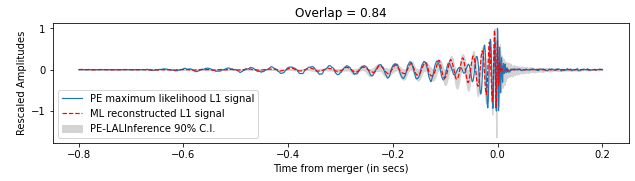

In [31]:
#plot_reconstructed(decoded_signals[0][::2][920:1024].astype(np.float64), np.squeeze(pe_reconst)[920:1024].astype(np.float64), new_upper[920:1024], new_lower[920:1024], psd)

plot_reconstructed(decoded_signals[0][::2][0:1024].astype(np.float64), np.squeeze(pe_reconst)[0:1024].astype(np.float64), new_upper[0:1024], new_lower[0:1024], psd)


# GW170809

In [9]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW170809_rec_signal_time_L1_1.dat",header=0,delimiter=" ")


In [10]:
np.where((input_data['#time,'].values > 1186302519.744) & (input_data['#time,'].values < 1186302519.746))[0]


array([7930, 7931])

In [11]:
7930 -(1024*0.8)


7110.8

In [12]:
7930 +(1024*0.2)


8134.8

In [13]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW170809.hdf', 'r')
strain = f1['GW170809-v1']['l1_strain'][()]


In [14]:
strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 2048)
strain = np.array(strain)


In [15]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [16]:
#from keras.models import load_model

model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
 
# load model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2058, 10, 32)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2058, 10, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2058, 5, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2058, 5, 16)      1552      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 2058, 5, 16)      0

In [17]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


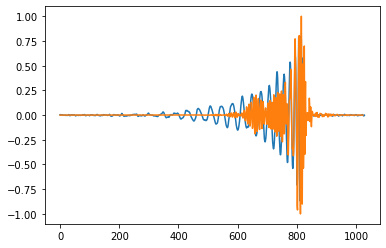

In [18]:
plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[7111:8135][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [19]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[7111:8135]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[7111:8135]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [20]:
with open('/fred/oz016/Chayan/samplegen_old/output/GW170809_L1_psd.dat', 'r') as file:
    freq = []
    psd = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            freq.append(col1)
            psd.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")
            
    freq = np.array(freq)
    psd = np.array(psd)


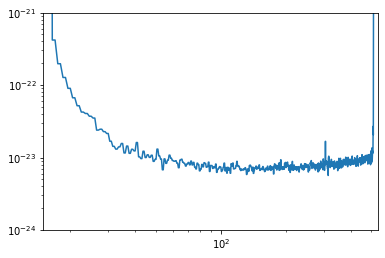

In [21]:
plt.plot(freq, np.sqrt(psd))
plt.xlim(15,)
plt.ylim(1e-24, 1e-21)
plt.xscale('log')
plt.yscale('log')


In [22]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170809_reconstruction_CI_dilated_CNN_10_timesteps_L1_cWB_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


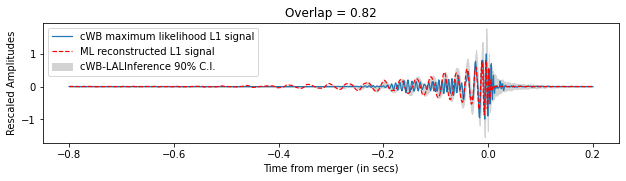

In [23]:
plot_reconstructed(decoded_signals[0][::2][0:1024].astype('float64'), np.squeeze(cwb_reconst).astype('float64'), new_upper, new_lower, psd)


# PE comparison

In [24]:
# Replace 'filename.dat' with your file path
with open('/fred/oz016/Chayan/samplegen_old/output/GW170809_maxl_li_signal_time_L1.dat', 'r') as file:
    time = []
    amp = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            time.append(col1)
            amp.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")

time = np.array(time)
amp = np.array(amp)


In [25]:
np.where((time > 1186302519.744) & (time < 1186302519.746))[0]


array([7930, 7931])

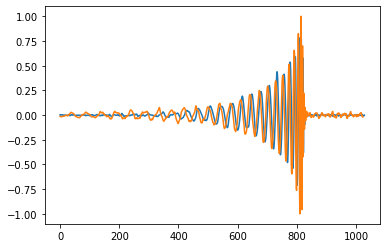

In [26]:
plt.plot(decoded_signals[0][::2])

pe_reconst = amp[7111:8135][None,:]
pe_reconst, maximum, minimum = _preprocess_data(pe_reconst,1,1024)

plt.plot(pe_reconst[0])


In [28]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[7111:8135]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[7111:8135]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [29]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='PE maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='PE-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170809_reconstruction_CI_dilated_CNN_10_timesteps_L1_PE_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


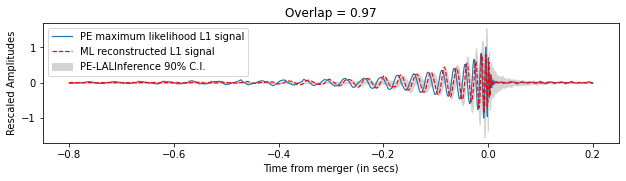

In [30]:
#plot_reconstructed(decoded_signals[0][::2][920:1024].astype(np.float64), np.squeeze(pe_reconst)[920:1024].astype(np.float64), new_upper[920:1024], new_lower[920:1024], psd)

plot_reconstructed(decoded_signals[0][::2][0:1024].astype(np.float64), np.squeeze(pe_reconst)[0:1024].astype(np.float64), new_upper[0:1024], new_lower[0:1024], psd)


# GW170814

In [31]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW170814_rec_signal_time_L1_1.dat",header=0,delimiter=" ")


In [32]:
np.where((input_data['#time,'].values > 1186741861.522) & (input_data['#time,'].values < 1186741861.524))[0]


array([7703, 7704])

In [33]:
7703 -(1024*0.8)


6883.8

In [34]:
7703 +(1024*0.2)


7907.8

In [35]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW170814.hdf', 'r')
strain = f1['GW170814-v3']['l1_strain'][()]


In [36]:
strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 2048)
strain = np.array(strain)


In [37]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [38]:
#from keras.models import load_model

model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
 
# load model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2058, 10, 32)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2058, 10, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2058, 5, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2058, 5, 16)      1552      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 2058, 5, 16)      0

In [39]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


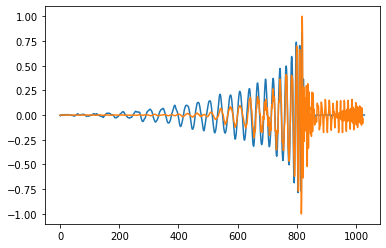

In [40]:
plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[6884:7908][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [41]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[6884:7908]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[6884:7908]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [42]:
with open('/fred/oz016/Chayan/samplegen_old/output/GW170814_L1_psd.dat', 'r') as file:
    freq = []
    psd = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            freq.append(col1)
            psd.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")
            
    freq = np.array(freq)
    psd = np.array(psd)


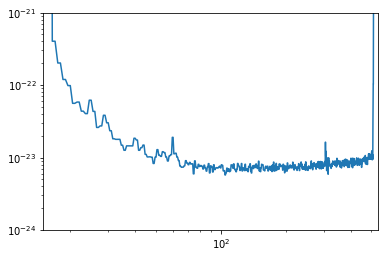

In [43]:
plt.plot(freq, np.sqrt(psd))
plt.xlim(15,)
plt.ylim(1e-24, 1e-21)
plt.xscale('log')
plt.yscale('log')


In [44]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170814_reconstruction_CI_dilated_CNN_10_timesteps_L1_cWB_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


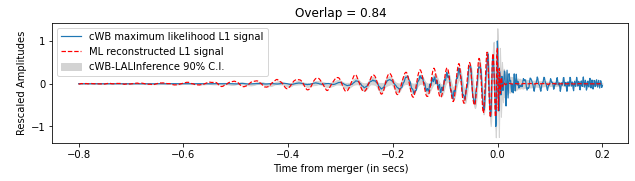

In [45]:
plot_reconstructed(decoded_signals[0][::2][0:1024].astype('float64'), np.squeeze(cwb_reconst).astype('float64'), new_upper, new_lower, psd)


# PE comparison

In [46]:
# Replace 'filename.dat' with your file path
with open('/fred/oz016/Chayan/samplegen_old/output/GW170814_maxl_li_signal_time_L1.dat', 'r') as file:
    time = []
    amp = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            time.append(col1)
            amp.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")

time = np.array(time)
amp = np.array(amp)


In [47]:
np.where((time > 1186741861.522) & (time < 1186741861.524))[0]


array([7703, 7704])

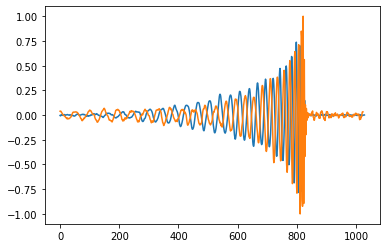

In [48]:
plt.plot(decoded_signals[0][::2])

pe_reconst = amp[6884:7908][None,:]
pe_reconst, maximum, minimum = _preprocess_data(pe_reconst,1,1024)

plt.plot(pe_reconst[0])


In [49]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[6884:7908]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[6884:7908]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [50]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='PE maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='PE-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170814_reconstruction_CI_dilated_CNN_10_timesteps_L1_PE_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


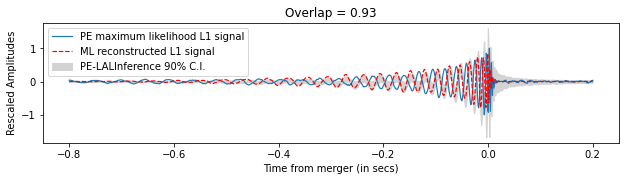

In [51]:
#plot_reconstructed(decoded_signals[0][::2][920:1024].astype(np.float64), np.squeeze(pe_reconst)[920:1024].astype(np.float64), new_upper[920:1024], new_lower[920:1024], psd)

plot_reconstructed(decoded_signals[0][::2][0:1024].astype(np.float64), np.squeeze(pe_reconst)[0:1024].astype(np.float64), new_upper[0:1024], new_lower[0:1024], psd)


# GW170818

In [52]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW170818_rec_signal_time_L1_1.dat",header=0,delimiter=" ")


In [53]:
np.where((input_data['#time,'].values > 1187058327.079) & (input_data['#time,'].values < 1187058327.081))[0]


array([8273, 8274])

In [54]:
8273 -(1024*0.8)


7453.8

In [55]:
8273 +(1024*0.2)


8477.8

In [56]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW170818.hdf', 'r')
strain = f1['GW170818-v1']['l1_strain'][()]


In [57]:
strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 2048)
strain = np.array(strain)


In [58]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [59]:
#from keras.models import load_model

model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
 
# load model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2058, 10, 32)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2058, 10, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2058, 5, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2058, 5, 16)      1552      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 2058, 5, 16)      0

In [60]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


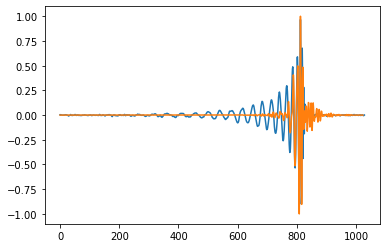

In [61]:
plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[7454:8478][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [62]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[7454:8478]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[7454:8478]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [63]:
with open('/fred/oz016/Chayan/samplegen_old/output/GW170818_L1_psd.dat', 'r') as file:
    freq = []
    psd = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            freq.append(col1)
            psd.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")
            
    freq = np.array(freq)
    psd = np.array(psd)


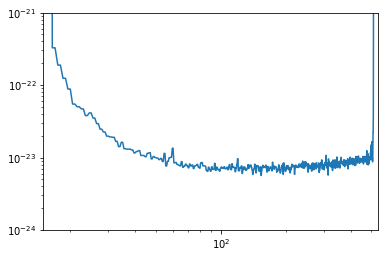

In [64]:
plt.plot(freq, np.sqrt(psd))
plt.xlim(15,)
plt.ylim(1e-24, 1e-21)
plt.xscale('log')
plt.yscale('log')


In [65]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170818_reconstruction_CI_dilated_CNN_10_timesteps_L1_cWB_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


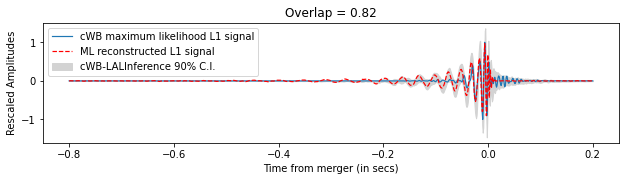

In [66]:
plot_reconstructed(decoded_signals[0][::2][0:1024].astype('float64'), np.squeeze(cwb_reconst).astype('float64'), new_upper, new_lower, psd)


# PE comparison

In [67]:
# Replace 'filename.dat' with your file path
with open('/fred/oz016/Chayan/samplegen_old/output/GW170818_maxl_li_signal_time_L1.dat', 'r') as file:
    time = []
    amp = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            time.append(col1)
            amp.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")

time = np.array(time)
amp = np.array(amp)


In [68]:
np.where((time > 1187058327.079) & (time < 1187058327.081))[0]


array([8273, 8274])

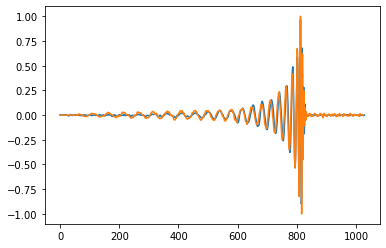

In [69]:
plt.plot(decoded_signals[0][::2])

pe_reconst = amp[7454:8478][None,:]
pe_reconst, maximum, minimum = _preprocess_data(pe_reconst,1,1024)

plt.plot(pe_reconst[0])


In [70]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[7454:8478]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[7454:8478]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [71]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='PE maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='PE-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170818_reconstruction_CI_dilated_CNN_10_timesteps_L1_PE_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


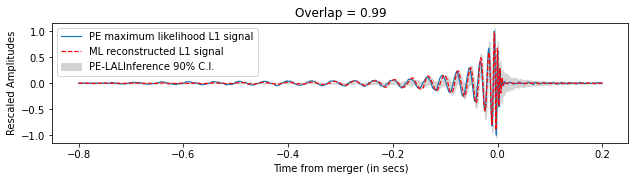

In [72]:
#plot_reconstructed(decoded_signals[0][::2][920:1024].astype(np.float64), np.squeeze(pe_reconst)[920:1024].astype(np.float64), new_upper[920:1024], new_lower[920:1024], psd)

plot_reconstructed(decoded_signals[0][::2][0:1024].astype(np.float64), np.squeeze(pe_reconst)[0:1024].astype(np.float64), new_upper[0:1024], new_lower[0:1024], psd)


# GW170823

In [73]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW170823_rec_signal_time_L1_1.dat",header=0,delimiter=" ")


In [75]:
np.where((input_data['#time,'].values > 1187529256.516) & (input_data['#time,'].values < 1187529256.518))[0]


array([7697, 7698])

In [76]:
7697 - (1024*0.8)

6877.8

In [77]:
7697 + (1024*0.2)

7901.8

In [78]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW170823.hdf', 'r')
strain = f1['GW170823-v1']['l1_strain'][()]


In [79]:
strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 2048)
strain = np.array(strain)


In [80]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [81]:
#from keras.models import load_model

model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
 
# load model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2058, 10, 32)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2058, 10, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2058, 5, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2058, 5, 16)      1552      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 2058, 5, 16)      0

In [82]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


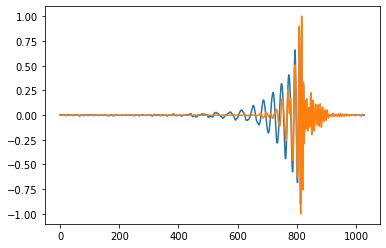

In [83]:
plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[6878:7902][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [84]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[6878:7902]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[6878:7902]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [85]:
with open('/fred/oz016/Chayan/samplegen_old/output/GW170823_L1_psd.dat', 'r') as file:
    freq = []
    psd = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            freq.append(col1)
            psd.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")
            
    freq = np.array(freq)
    psd = np.array(psd)


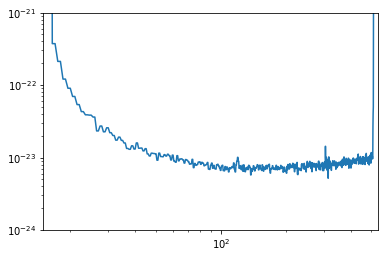

In [86]:
plt.plot(freq, np.sqrt(psd))
plt.xlim(15,)
plt.ylim(1e-24, 1e-21)
plt.xscale('log')
plt.yscale('log')


In [87]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170823_reconstruction_CI_dilated_CNN_10_timesteps_L1_cWB_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


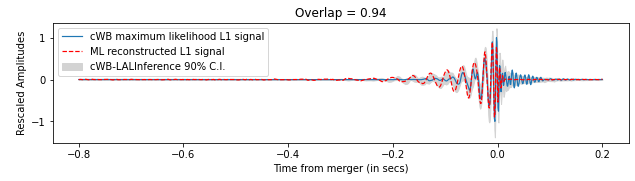

In [88]:
plot_reconstructed(decoded_signals[0][::2][0:1024].astype('float64'), np.squeeze(cwb_reconst).astype('float64'), new_upper, new_lower, psd)


# PE comparison

In [89]:
# Replace 'filename.dat' with your file path
with open('/fred/oz016/Chayan/samplegen_old/output/GW170823_maxl_li_signal_time_L1.dat', 'r') as file:
    time = []
    amp = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            time.append(col1)
            amp.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")

time = np.array(time)
amp = np.array(amp)


In [90]:
np.where((time > 1187529256.516) & (time < 1187529256.518))[0]


array([7697, 7698])

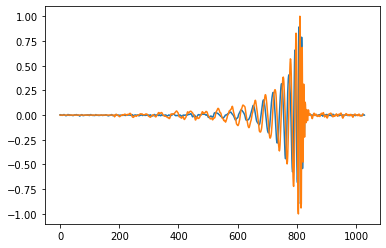

In [91]:
plt.plot(decoded_signals[0][::2])

pe_reconst = amp[6878:7902][None,:]
pe_reconst, maximum, minimum = _preprocess_data(pe_reconst,1,1024)

plt.plot(pe_reconst[0])


In [92]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[6878:7902]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[6878:7902]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [93]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='PE maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='PE-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170823_reconstruction_CI_dilated_CNN_10_timesteps_L1_PE_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


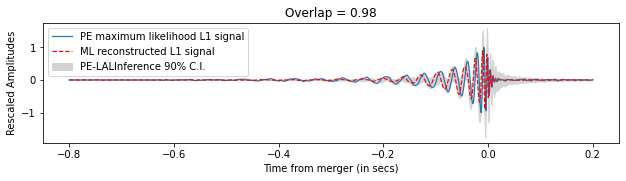

In [94]:
#plot_reconstructed(decoded_signals[0][::2][920:1024].astype(np.float64), np.squeeze(pe_reconst)[920:1024].astype(np.float64), new_upper[920:1024], new_lower[920:1024], psd)

plot_reconstructed(decoded_signals[0][::2][0:1024].astype(np.float64), np.squeeze(pe_reconst)[0:1024].astype(np.float64), new_upper[0:1024], new_lower[0:1024], psd)


# GW170608

In [6]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW170608_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [7]:
np.where((input_data['#time,'].values > 1180922494.491) & (input_data['#time,'].values < 1180922494.493))[0]


array([8695, 8696])

In [8]:
8695 - (1024*0.8)

7875.8

In [9]:
8695 + (1024*0.2)

8899.8

In [10]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW170608.hdf', 'r')
strain = f1['GW170608-v3']['l1_strain'][()]


In [11]:
strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 2048)
strain = np.array(strain)


In [12]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [13]:
#from keras.models import load_model

model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

# load model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2058, 10, 32)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2058, 10, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2058, 5, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2058, 5, 16)      1552      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 2058, 5, 16)      0

In [14]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


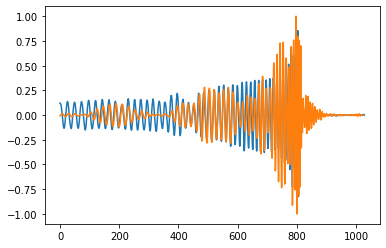

In [15]:
plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[7876:8900][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [16]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[7876:8900]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[7876:8900]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [17]:
with open('/fred/oz016/Chayan/samplegen_old/output/GW170608_L1_psd.dat', 'r') as file:
    freq = []
    psd = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            freq.append(col1)
            psd.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")
            
    freq = np.array(freq)
    psd = np.array(psd)


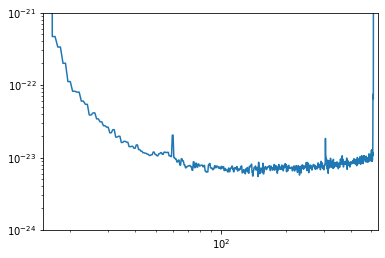

In [18]:
plt.plot(freq, np.sqrt(psd))
plt.xlim(15,)
plt.ylim(1e-24, 1e-21)
plt.xscale('log')
plt.yscale('log')


In [19]:
from scipy.fft import fft, ifft

def get_snr_frac(decoded_signal, pure_signal):
    
    h_fft = fft(pure_signal)
    template_fft = fft(pure_signal)
    snr_freq = (h_fft * template_fft.conjugate())
    snr_time = np.abs(ifft(snr_freq))
    optimal_snr_ligo = np.sqrt(np.max(snr_time))
    
    h_fft = fft(decoded_signal)
    template_fft = fft(decoded_signal)
    snr_freq = (h_fft * template_fft.conjugate())
    snr_time = np.abs(ifft(snr_freq))
    optimal_snr_ml = np.sqrt(np.max(snr_time))

    return optimal_snr_ml/optimal_snr_ligo


In [20]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    snr_frac = get_snr_frac(decoded_signals.squeeze(), pure_signals)
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}, SNR fraction recovered = {snr_frac}'.format(m=np.round(m,2), snr_frac=np.round(snr_frac,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170608_reconstruction_CI_dilated_CNN_10_timesteps_L1_cWB_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


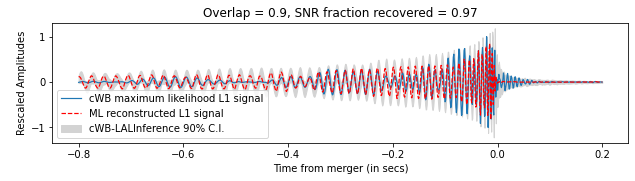

In [21]:
plot_reconstructed(decoded_signals[0][::2][0:1024].astype('float64'), np.squeeze(cwb_reconst).astype('float64'), new_upper, new_lower, psd)


# PE comparison

In [22]:
# Replace 'filename.dat' with your file path
with open('/fred/oz016/Chayan/samplegen_old/output/GW170608_maxl_li_signal_time_L1.dat', 'r') as file:
    time = []
    amp = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            time.append(col1)
            amp.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")

time = np.array(time)
amp = np.array(amp)


In [23]:
np.where((time > 1180922494.491) & (time < 1180922494.493))[0]


array([8695, 8696])

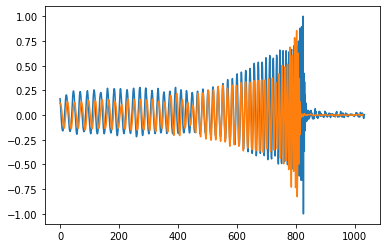

In [24]:

pe_reconst = amp[7866:8900][None,:]
pe_reconst, maximum, minimum = _preprocess_data(pe_reconst,1,1014)

plt.plot(pe_reconst[0])

plt.plot(decoded_signals[0][::2])



In [25]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[7876:8900]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[7876:8900]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [33]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals_cwb, pure_signals_pe, upper_90, lower_90, psd, before=0.8, after=0.2):
    time_buffer = 1
    sample_rate = 1024
    
    length_signal = (before + after)*sample_rate
    
    low_index = round((0.8-before)*(sample_rate*time_buffer))
    upper_index = round((sample_rate*time_buffer) - (0.2-after)*(sample_rate*time_buffer))
    
    pure_signals_cwb = pure_signals_cwb[low_index:upper_index]
    pure_signals_pe = pure_signals_pe[low_index:upper_index]
    decoded_signals = decoded_signals[low_index:upper_index]
    
    upper_90 = upper_90[low_index:upper_index]
    lower_90 = lower_90[low_index:upper_index]

    time = np.linspace(-before, after, round(length_signal))
    
    if(len(pure_signals_pe)< len(time)):
        length = abs(len(pure_signals_pe) - len(time))
        pure_signals_pe = np.pad(pure_signals_pe, (length,), 'constant', constant_values=(0,))[length:]

    # Create subplots
#    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    
    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_cwb_ts = TimeSeries(pure_signals_cwb.squeeze(), delta_t = 1.0/1024)
    X_test_pure_pe_ts = TimeSeries(pure_signals_pe.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_cwb_ts.resize(tlen)
    X_test_pure_pe_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_cwb_ts.max() != 0.0):
        m_cwb = Overlap_calc(X_test_pure_cwb_ts,decoded_signals_ts,psd)
        m_pe = Overlap_calc(X_test_pure_pe_ts,decoded_signals_ts,psd)
    else:
        m_cwb = 1
        m_pe = 1
        
    snr_frac_cwb = get_snr_frac(decoded_signals.squeeze(), pure_signals_cwb)
    snr_frac_pe = get_snr_frac(decoded_signals.squeeze(), pure_signals_pe)
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
    
    
    fig = plt.figure(figsize=(10,5))
    
    # Plot for decoded signals and pure_signals_cwb
    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap (cWB) = {m_cwb}, Overlap (LAL) = {m_pe}, SNR_frac (cWB) = {snr_frac_cwb}, SNR_frac (LAL) = {snr_frac_pe}'.format(m_cwb=np.round(m_cwb,2), m_pe=np.round(m_pe,2), snr_frac_cwb=np.round(snr_frac_cwb,2),snr_frac_pe=np.round(snr_frac_pe,2)))
    signal_axes.plot(time, pure_signals_cwb, label='cWB max likelihood L1 signal')
    signal_axes.plot(time, pure_signals_pe, label='LAL max likelihood L1 signal')
    signal_axes.plot(time, decoded_signals, label='ML reconstructed L1 signal', color='red', linestyle='dashed')
    signal_axes.fill_between(time, lower_90, upper_90, color='lightgrey', label='cWB 90% C.I.')
    signal_axes.set_ylabel('Rescaled_amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend(loc='lower left', fontsize='small')
    
    plt.savefig('IMBH_test/O2_real_events/GW170608_reconstruction_CI_dilated_CNN_10_timesteps_L1_PE_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


<Figure size 432x288 with 0 Axes>

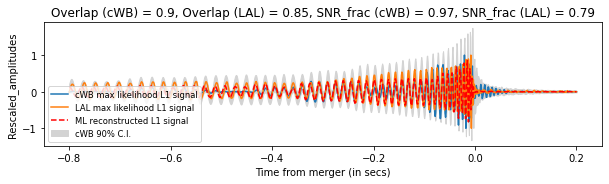

In [34]:
#plot_reconstructed(decoded_signals[0][::2][920:1024].astype(np.float64), np.squeeze(pe_reconst)[920:1024].astype(np.float64), new_upper[920:1024], new_lower[920:1024], psd)

plot_reconstructed(decoded_signals[0][::2][0:1024].astype(np.float64), np.squeeze(cwb_reconst)[0:1024].astype(np.float64), np.squeeze(pe_reconst)[15:1024].astype(np.float64), new_upper[0:1024], new_lower[0:1024], psd, 0.8, 0.2)


In [ ]:
import pycbc.catalog

c = pycbc.catalog.Catalog(source='gwtc-2.1')

# Names of mergers in the catalog
print(c.names)

# Approximate GPS time of the mergers
print([c[m].time for m in c])
